## Physics Informed Neural Networks to Approximate Solution of PDEs

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
from torch.utils.data import DataLoader

from Common import NeuralNet

torch.autograd.set_detect_anomaly(True)
torch.manual_seed(128)

In [2]:
class Pinns:
    def __init__(self, n_int_, n_sb_, n_tb_):
        self.n_int = n_int_
        self.n_sb = n_sb_
        self.n_tb = n_tb_

        # PDE parameters
        self.alpha_f = 0.005
        self.h_f = 5.0
        self.T_hot = 4.0
        self.T_cold = 1.0
        self.T_0 = 1.0

        # Extrema of the solution domain (t,x) in [0,0.1]x[-1,1]
        self.domain_extrema = torch.tensor([[0, 8],  # Time dimension
                                            [0, 1]])  # Space dimension

        # Number of space dimensions
        self.space_dimensions = 1

        # Parameter to balance role of data and PDE
        self.lambda_u = 10

        # FF Dense NN to approximate the solution of the underlying heat equation
        self.approximate_solution = NeuralNet(input_dimension=self.domain_extrema.shape[0], output_dimension=1,
                                              n_hidden_layers=4,
                                              neurons=20,
                                              regularization_param=0.,
                                              regularization_exp=2.,
                                              retrain_seed=42)

        # FF Dense NN to approximate the conductivity we wish to infer
        self.approximate_coefficient = NeuralNet(input_dimension=self.domain_extrema.shape[0], output_dimension=1,
                                                 n_hidden_layers=4,
                                                 neurons=20,
                                                 regularization_param=0.,
                                                 regularization_exp=2.,
                                                 retrain_seed=42)

        # Generator of Sobol sequences
        self.soboleng = torch.quasirandom.SobolEngine(dimension=self.domain_extrema.shape[0])

        # Training sets S_sb, S_tb, S_int as torch dataloader
        self.training_set_sb, self.training_set_tb, self.training_set_int, self.training_set_meas = self.assemble_datasets()

    ################################################################################################
    # Function to linearly transform a tensor whose value are between 0 and 1
    # to a tensor whose values are between the domain extrema
    def convert(self, tens):
        assert (tens.shape[1] == self.domain_extrema.shape[0])
        return tens * (self.domain_extrema[:, 1] - self.domain_extrema[:, 0]) + self.domain_extrema[:, 0]

    # Initial condition to solve the heat equation u0(x)=-sin(pi x)
    def initial_condition(self, x):
        return torch.full([len(x), 1], self.T_0)

    def fluid_velocity(self, inputs):  # finished
        Uf = torch.full(inputs.shape, 0.0)
        for i in range(len(inputs)):
            if inputs[i, :] < 1 or inputs[i, :] < 5 and inputs[i, :] > 4:
                Uf[i, :] = 1.0
            elif inputs[i, :] > 2 and inputs[i, :] < 3 or inputs[i, :] > 6 and inputs[i, :] < 7:
                Uf[i, :] = -1.0
        return Uf

    ################################################################################################
    # Function returning the input-output tensor required to assemble the training set S_tb corresponding to the temporal boundary
    def add_temporal_boundary_points(self):
        t0 = self.domain_extrema[0, 0]
        input_tb = self.convert(self.soboleng.draw(self.n_tb))
        input_tb[:, 0] = torch.full(input_tb[:, 0].shape, t0)
        output_tb = self.initial_condition(input_tb[:, 1]).reshape(-1, 1)

        return input_tb, output_tb

    # Function returning the input-output tensor required to assemble the training set S_sb corresponding to the spatial boundary
    def add_spatial_boundary_points(self):
        x0 = self.domain_extrema[1, 0]
        xL = self.domain_extrema[1, 1]

        input_sb = self.convert(self.soboleng.draw(self.n_sb))

        input_sb_0 = torch.clone(input_sb)
        input_sb_0[:, 1] = torch.full(input_sb_0[:, 1].shape, x0)

        input_sb_L = torch.clone(input_sb)
        input_sb_L[:, 1] = torch.full(input_sb_L[:, 1].shape, xL)

        output_sb_0 = torch.zeros((input_sb.shape[0], 1))
        output_sb_L = torch.zeros((input_sb.shape[0], 1))

        return torch.cat([input_sb_0, input_sb_L], 0), torch.cat([output_sb_0, output_sb_L], 0)

    #  Function returning the input-output tensor required to assemble the training set S_int corresponding to the interior domain where the PDE is enforced
    def add_interior_points(self):
        input_int = self.convert(self.soboleng.draw(self.n_int))
        output_int = torch.zeros((input_int.shape[0], 1))
        return input_int, output_int

    def get_measurement_data(self):  # sensor_data[:, 0] -> t; sensor_data[:, 1] -> x
        sensor_data = pd.read_table('DataSolution.txt', sep=',').values

        input_meas = torch.tensor(sensor_data[:, 0:2], dtype=torch.float)
        output_meas = torch.tensor(sensor_data[:, 2].reshape(-1, 1), dtype=torch.float)

        return input_meas, output_meas

    # Function returning the training sets S_sb, S_tb, S_int as dataloader
    def assemble_datasets(self):  # ! need to take the measurement as dataloader
        input_sb, output_sb = self.add_spatial_boundary_points()  # S_sb
        input_tb, output_tb = self.add_temporal_boundary_points()  # S_tb
        input_int, output_int = self.add_interior_points()  # S_int
        input_meas, output_meas = self.get_measurement_data()  # S_meas

        training_set_sb = DataLoader(torch.utils.data.TensorDataset(input_sb, output_sb),
                                     batch_size=2 * self.space_dimensions * self.n_sb, shuffle=False)
        training_set_tb = DataLoader(torch.utils.data.TensorDataset(input_tb, output_tb), batch_size=self.n_tb,
                                     shuffle=False)
        training_set_int = DataLoader(torch.utils.data.TensorDataset(input_int, output_int), batch_size=self.n_int,
                                      shuffle=False)
        training_set_meas = DataLoader(torch.utils.data.TensorDataset(input_meas, output_meas), batch_size=len(input_meas),
                                       shuffle=True)

        return training_set_sb, training_set_tb, training_set_int, training_set_meas

    ################################################################################################
    # Function to compute the terms required in the definition of the TEMPORAL boundary residual
    def apply_initial_condition(self, input_tb):
        u_pred_tb = self.approximate_solution(input_tb)
        return u_pred_tb

    # Function to compute the terms required in the definition of the SPATIAL boundary residual
    def apply_boundary_conditions(self, input_sb):
        u_pred_sb = self.approximate_solution(input_sb)

        return u_pred_sb

    # Function to compute the PDE residuals
    def compute_pde_residual(self, input_int):  # finished, wait for verifying
        input_int.requires_grad = True
        Tf = self.approximate_solution(input_int).reshape(-1, )
        Ts = self.approximate_coefficient(input_int).reshape(-1, )

        # grad compute the gradient of a "SCALAR" function L with respect to some input nxm TENSOR Z=[[x1, y1],[x2,y2],[x3,y3],...,[xn,yn]], m=2
        # it returns grad_L = [[dL/dx1, dL/dy1],[dL/dx2, dL/dy2],[dL/dx3, dL/dy3],...,[dL/dxn, dL/dyn]]
        # Note: pytorch considers a tensor [u1, u2,u3, ... ,un] a vectorial function
        # whereas sum_u = u1 + u2 u3 + u4 + ... + un as a "scalar" one

        # In our case ui = u(xi), therefore the line below returns:
        # grad_u = [[dsum_u/dx1, dsum_u/dy1],[dsum_u/dx2, dsum_u/dy2],[dsum_u/dx3, dL/dy3],...,[dsum_u/dxm, dsum_u/dyn]]
        # and dsum_u/dxi = d(u1 + u2 u3 + u4 + ... + un)/dxi = d(u(x1) + u(x2) u3(x3) + u4(x4) + ... + u(xn))/dxi = dui/dxi
        grad_Tf = torch.autograd.grad(Tf.sum(), input_int, create_graph=True)[0]
        grad_Tf_t = grad_Tf[:, 0]
        grad_Tf_x = grad_Tf[:, 1]
        grad_Tf_xx = torch.autograd.grad(grad_Tf_x.sum(), input_int, create_graph=True)[0][:, 1]

        U_f = self.fluid_velocity(input_int[:, 0:1]).reshape(-1,)

        residual = grad_Tf_t + U_f * grad_Tf_x - self.alpha_f * grad_Tf_xx + self.h_f * (Tf - Ts)

        return residual.reshape(-1, )

    def compute_bc_residual(self, input_bc):
        input_bc.requires_grad = True

        Tf = self.approximate_solution(input_bc)

        # solid
        grad_Tf = torch.autograd.grad(Tf.sum(), input_bc, create_graph=True)[0]
        grad_Tf_x = grad_Tf[:, 1]

        residual = grad_Tf_x
        return residual.reshape(-1, )

    # Function to compute the total loss (weighted sum of spatial boundary loss, temporal boundary loss and interior loss)
    def compute_loss(self, inp_train_sb, u_train_sb, inp_train_tb, u_train_tb, inp_train_int, inp_train_meas,
                     u_train_meas, verbose=True):
        u_pred_tb = self.apply_initial_condition(inp_train_tb)
        u_pred_meas = self.approximate_solution(inp_train_meas)

        # separate BC
        inp_train_sbh = torch.zeros((1, 2), dtype=float)
        inp_train_sbl = torch.zeros((1, 2), dtype=float)
        inp_train_sb0 = torch.zeros((1, 2), dtype=float)
        for i in range(len(inp_train_sb[:, 0])):
            if (inp_train_sb[i, 0] < 1 and inp_train_sb[i, 1] == 0) or (
                    inp_train_sb[i, 0] > 4 and inp_train_sb[i, 0] < 5 and inp_train_sb[i, 1] == 0):
                inp_train_sbh = torch.cat((inp_train_sbh, inp_train_sb[i:i + 1, :]), 0)
            elif (inp_train_sb[i, 0] > 2 and inp_train_sb[i, 0] < 3 and inp_train_sb[i, 1] == 1) or (
                    inp_train_sb[i, 0] > 6 and inp_train_sb[i, 0] < 7 and inp_train_sb[i, 1] == 1):
                inp_train_sbl = torch.cat((inp_train_sbl, inp_train_sb[i:i + 1, :]), 0)
            else:
                inp_train_sb0 = torch.cat((inp_train_sb0, inp_train_sb[i:i + 1, :]), 0)
        inp_train_sbh = inp_train_sbh[1:, :].float()
        inp_train_sbl = inp_train_sbl[1:, :].float()
        inp_train_sb0 = inp_train_sb0[1:, :].float()

        assert (u_pred_tb.shape[1] == u_train_tb.shape[1])
        assert (u_pred_meas.shape[1] == u_train_meas.shape[1])

        r_int = self.compute_pde_residual(inp_train_int)
        r_tb = u_train_tb - u_pred_tb
        r_sbh = self.apply_boundary_conditions(inp_train_sbh) - self.T_hot
        r_sbl = self.apply_boundary_conditions(inp_train_sbl) - self.T_cold
        r_sb0 = self.compute_bc_residual(inp_train_sb0)
        r_meas = u_train_meas - u_pred_meas

        loss_int = torch.mean(abs(r_int) ** 2)
        loss_tb = torch.mean(abs(r_tb) ** 2)
        loss_sb = torch.mean(abs(r_sbh) ** 2) + torch.mean(abs(r_sbl) ** 2) + torch.mean(abs(r_sb0) ** 2)
        loss_meas = torch.mean(abs(r_meas) ** 2)

        loss_u = loss_sb + loss_tb + loss_meas

        loss = torch.log10(self.lambda_u * loss_u + loss_int)
        if verbose: print("Total loss: ", round(loss.item(), 4), "| PDE Loss: ", round(torch.log10(loss_int).item(), 4),
                          "| Function Loss: ", round(torch.log10(loss_u).item(), 4))

        return loss

    ################################################################################################
    def fit(self, num_epochs, optimizer, verbose=True):
        history = list()

        # Loop over epochs
        for epoch in range(num_epochs):
            if verbose: print("################################ ", epoch, " ################################")

            for j, ((inp_train_sb, u_train_sb), (inp_train_tb, u_train_tb), (inp_train_int, u_train_int),
                    (inp_train_meas, u_train_meas)) in enumerate(
                    zip(self.training_set_sb, self.training_set_tb, self.training_set_int, self.training_set_meas)):
                def closure():
                    optimizer.zero_grad()
                    loss = self.compute_loss(inp_train_sb, u_train_sb, inp_train_tb, u_train_tb, inp_train_int,
                                             inp_train_meas, u_train_meas, verbose=verbose)
                    loss.backward()

                    history.append(loss.item())
                    return loss

                optimizer.step(closure=closure)

        print('Final Loss: ', history[-1])

        return history
    ################################################################################################
    def save_checkpoint(self, save_dir):
        '''save model and optimizer'''

        torch.save({
            'model_state_dict_solu': self.approximate_solution.state_dict(),
            'model_state_dict_coef': self.approximate_coefficient.state_dict()
        }, save_dir)


    def load_checkpoint(self, save_dir):
        '''load model and optimizer'''

        checkpoint = torch.load(save_dir)
        self.approximate_solution.load_state_dict(checkpoint['model_state_dict_solu'])
        self.approximate_coefficient.load_state_dict(checkpoint['model_state_dict_coef'])

        print('Pretrained model loaded!')
        
    ################################################################################################
    def plotting(self):
        input_meas_, output_meas_ = self.get_measurement_data()

        approximate_conductivity = self.approximate_coefficient(input_meas_).reshape(-1, )
        output = self.approximate_solution(input_meas_).reshape(-1, )

        fig, axs = plt.subplots(1, 2, figsize=(16, 8), dpi=150)
        im1 = axs[0].scatter(inputs_meas_[:, 0].detach(), inputs_meas_[:, 1].detach(), c=output.detach(), cmap="jet")
        axs[0].set_xlabel("t")
        axs[0].set_ylabel("x")
        plt.colorbar(im1, ax=axs[0])
        axs[0].grid(True, which="both", ls=":")
        im2 = axs[1].scatter(inputs_meas_[:, 0].detach(), inputs_meas_[:, 1].detach(), c=approximate_conductivity.detach(),
                             cmap="jet")
        axs[1].set_xlabel("t")
        axs[1].set_ylabel("x")
        plt.colorbar(im2, ax=axs[1])
        axs[1].grid(True, which="both", ls=":")
        axs[0].set_title("Approximate Solution")
        axs[1].set_title("Approximate Conductivity")

        plt.show()

In [3]:
n_int = 256
n_sb = 64
n_tb = 64

pinn = Pinns(n_int, n_sb, n_tb)

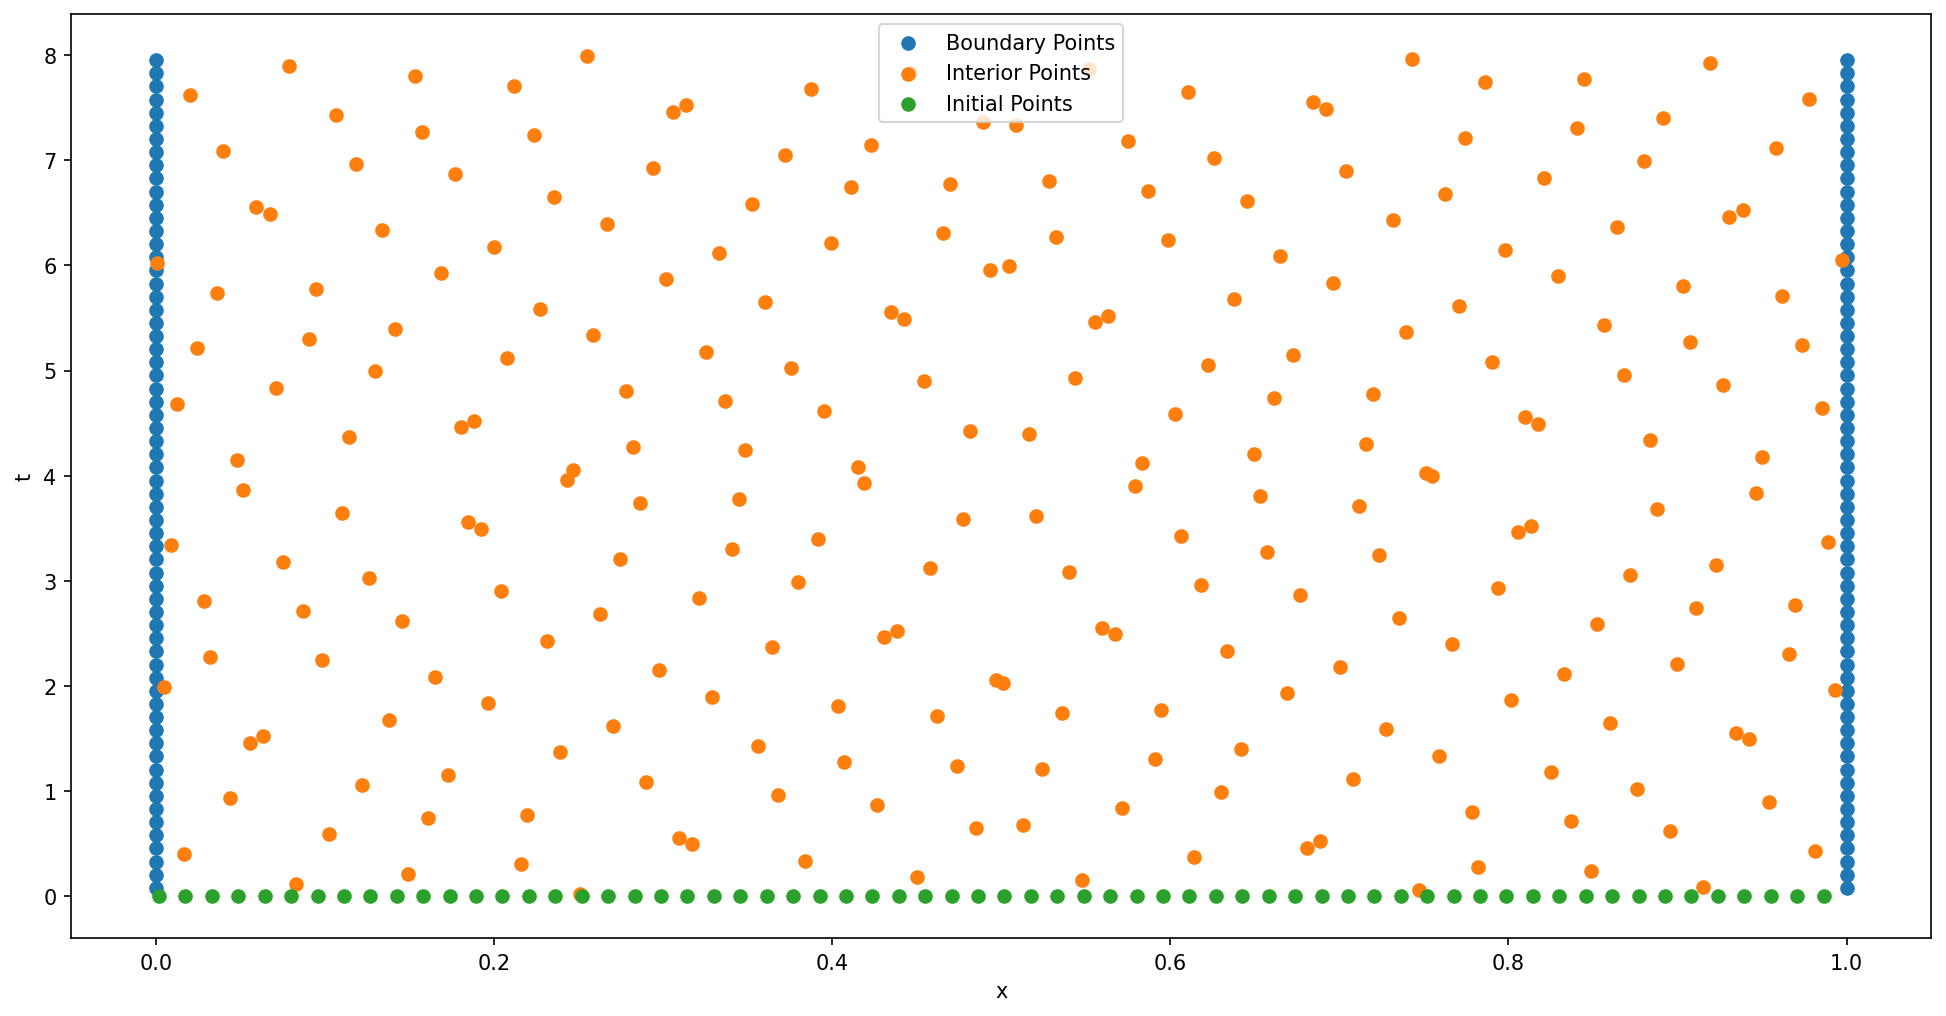

In [4]:
# Plot the input training points
input_sb_, output_sb_ = pinn.add_spatial_boundary_points()
input_tb_, output_tb_ = pinn.add_temporal_boundary_points()
input_int_, output_int_ = pinn.add_interior_points()
input_meas_, output_meas_ = pinn.get_measurement_data()

plt.figure(figsize=(16, 8), dpi=150)
plt.scatter(input_sb_[:, 1].detach().numpy(), input_sb_[:, 0].detach().numpy(), label="Boundary Points")
plt.scatter(input_int_[:, 1].detach().numpy(), input_int_[:, 0].detach().numpy(), label="Interior Points")
plt.scatter(input_tb_[:, 1].detach().numpy(), input_tb_[:, 0].detach().numpy(), label="Initial Points")
#plt.scatter(input_meas_[:, 1].detach().numpy(), input_meas_[:, 0].detach().numpy(), label="Sensors Points", marker="*")
plt.xlabel("x")
plt.ylabel("t")
plt.legend()
plt.show()

In [5]:
n_epochs = 1
optimizer_LBFGS = optim.LBFGS(list(pinn.approximate_solution.parameters()) + list(pinn.approximate_coefficient.parameters()),
                              lr=float(0.6),
                              max_iter=10000,
                              max_eval=50000,
                              history_size=150,
                              line_search_fn="strong_wolfe",
                              tolerance_change=1.0 * np.finfo(float).eps)
optimizer_ADAM = optim.Adam(pinn.approximate_solution.parameters(),
                            lr=float(0.000005))

Pretrained model loaded!
################################  0  ################################
Total loss:  -1.1399 | PDE Loss:  -1.4942 | Function Loss:  -2.3936
Total loss:  2.9434 | PDE Loss:  1.686 | Function Loss:  1.9187
Total loss:  -0.7641 | PDE Loss:  -1.4611 | Function Loss:  -1.8615
Total loss:  -1.1342 | PDE Loss:  -1.4937 | Function Loss:  -2.3837
Total loss:  -1.1399 | PDE Loss:  -1.4942 | Function Loss:  -2.3936
Total loss:  -1.1399 | PDE Loss:  -1.4942 | Function Loss:  -2.3936
Total loss:  -1.1399 | PDE Loss:  -1.4942 | Function Loss:  -2.3936
Total loss:  -1.1399 | PDE Loss:  -1.4942 | Function Loss:  -2.3936
Total loss:  -1.1399 | PDE Loss:  -1.4942 | Function Loss:  -2.3936
Total loss:  -1.1399 | PDE Loss:  -1.4942 | Function Loss:  -2.3936
Final Loss:  -1.1399465799331665


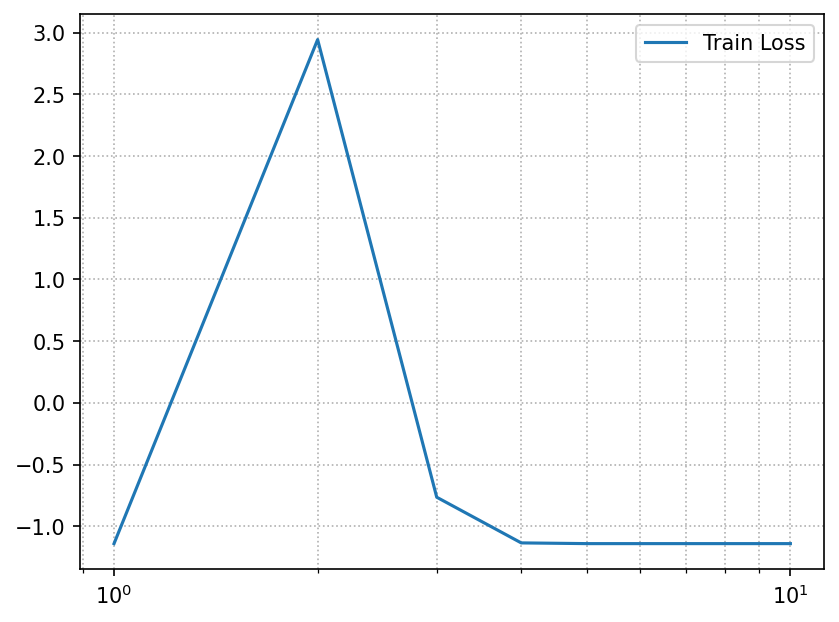

In [6]:
pre_model_save_path = './model/ADAM_2.pt'
save_path = './model/ADAM_3.pt'
scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ADAM, step_size=100,gamma=0.98)

pinn.load_checkpoint(pre_model_save_path)
hist = pinn.fit(num_epochs=n_epochs,
                optimizer=optimizer_LBFGS,
                verbose=True)

pinn.save_checkpoint(save_path)

plt.figure(dpi=150)
plt.grid(True, which="both", ls=":")
plt.plot(np.arange(1, len(hist) + 1), hist, label="Train Loss")
plt.xscale("log")
plt.legend()

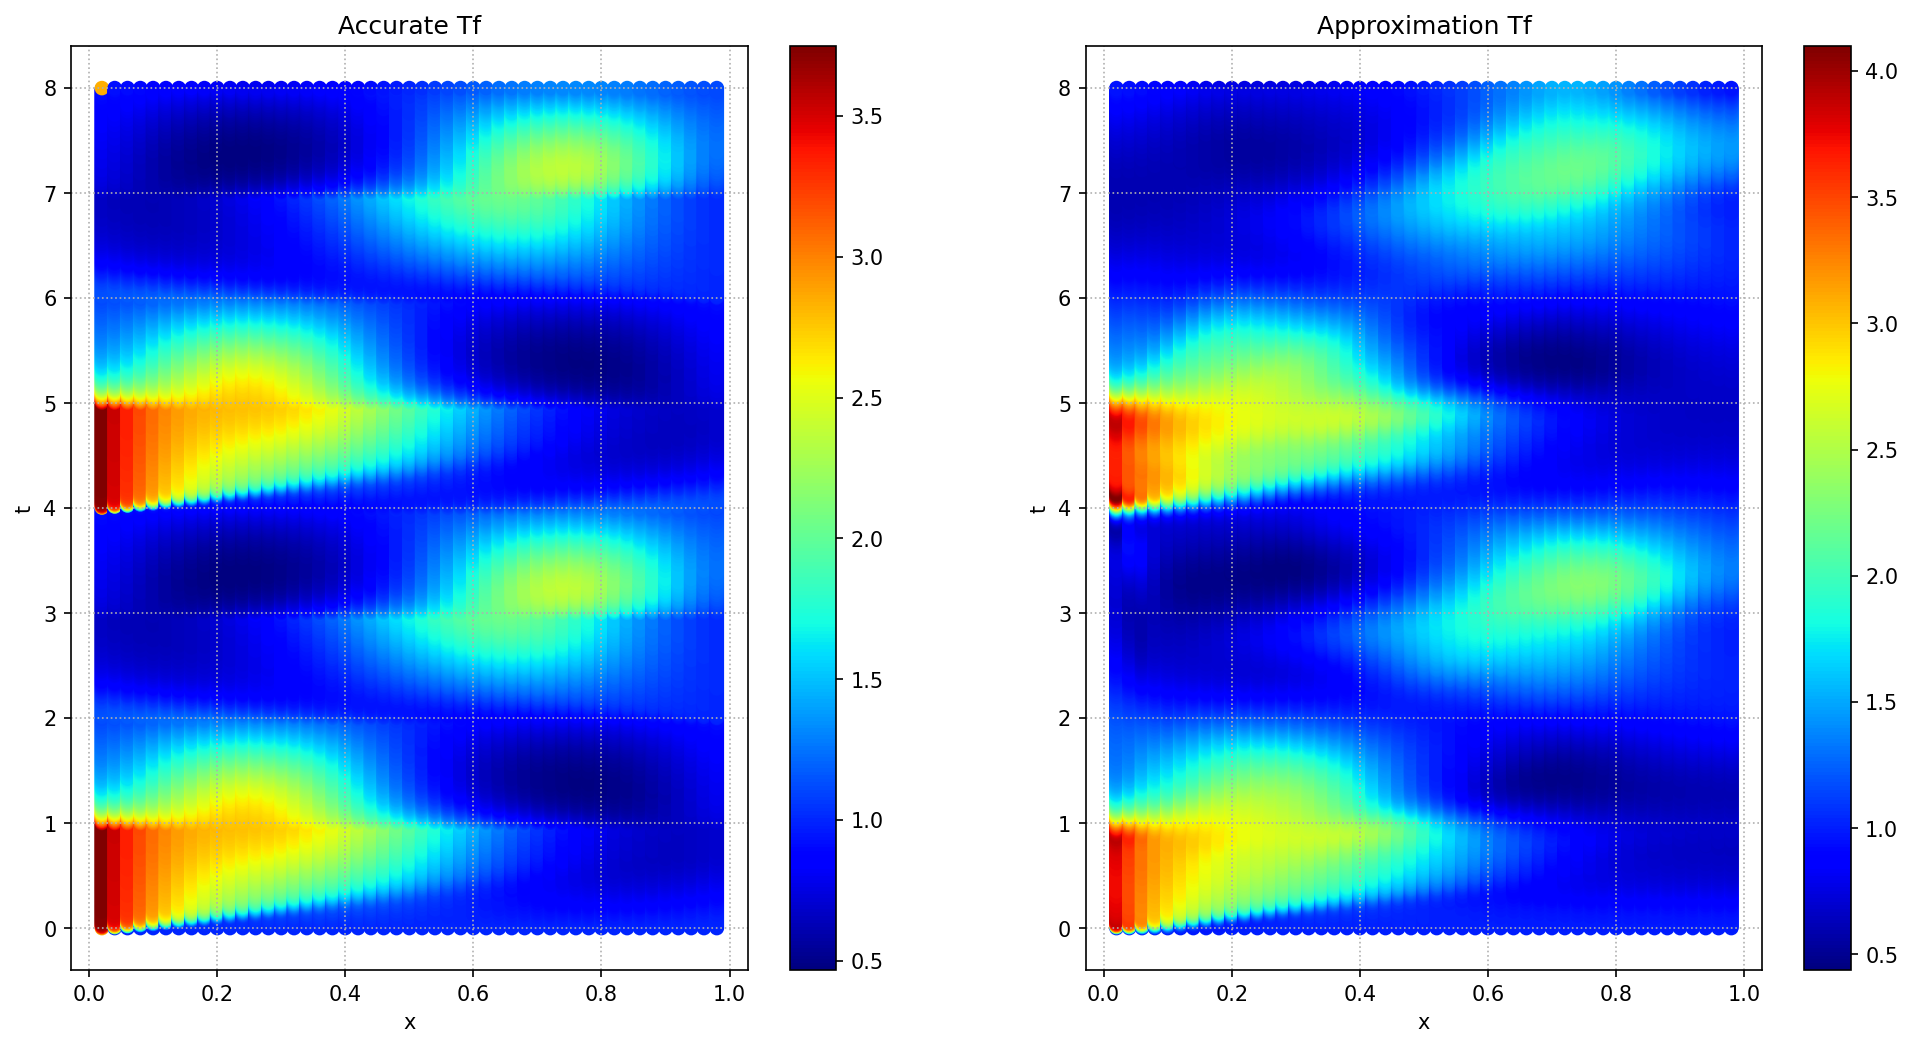

In [8]:
input_meas_, output_meas_ = pinn.get_measurement_data()

approximate_conductivity = pinn.approximate_coefficient(input_meas_).reshape(-1, )
output = pinn.approximate_solution(input_meas_).reshape(-1, )

fig, axs = plt.subplots(1, 2, figsize=(16, 8), dpi=150)
im1 = axs[0].scatter(input_meas_[:, 1].detach(), input_meas_[:, 0].detach(), c=output_meas_[:, :].detach(), cmap="jet")
axs[0].set_xlabel("x")
axs[0].set_ylabel("t")
plt.colorbar(im1, ax=axs[0])
axs[0].grid(True, which="both", ls=":")
im2 = axs[1].scatter(input_meas_[:, 1].detach(), input_meas_[:, 0].detach(), c=output.detach().detach(),
                             cmap="jet")
axs[1].set_xlabel("x")
axs[1].set_ylabel("t")
plt.colorbar(im2, ax=axs[1])
axs[1].grid(True, which="both", ls=":")
axs[0].set_title("Accurate Tf")
axs[1].set_title("Approximation Tf")
plt.show()

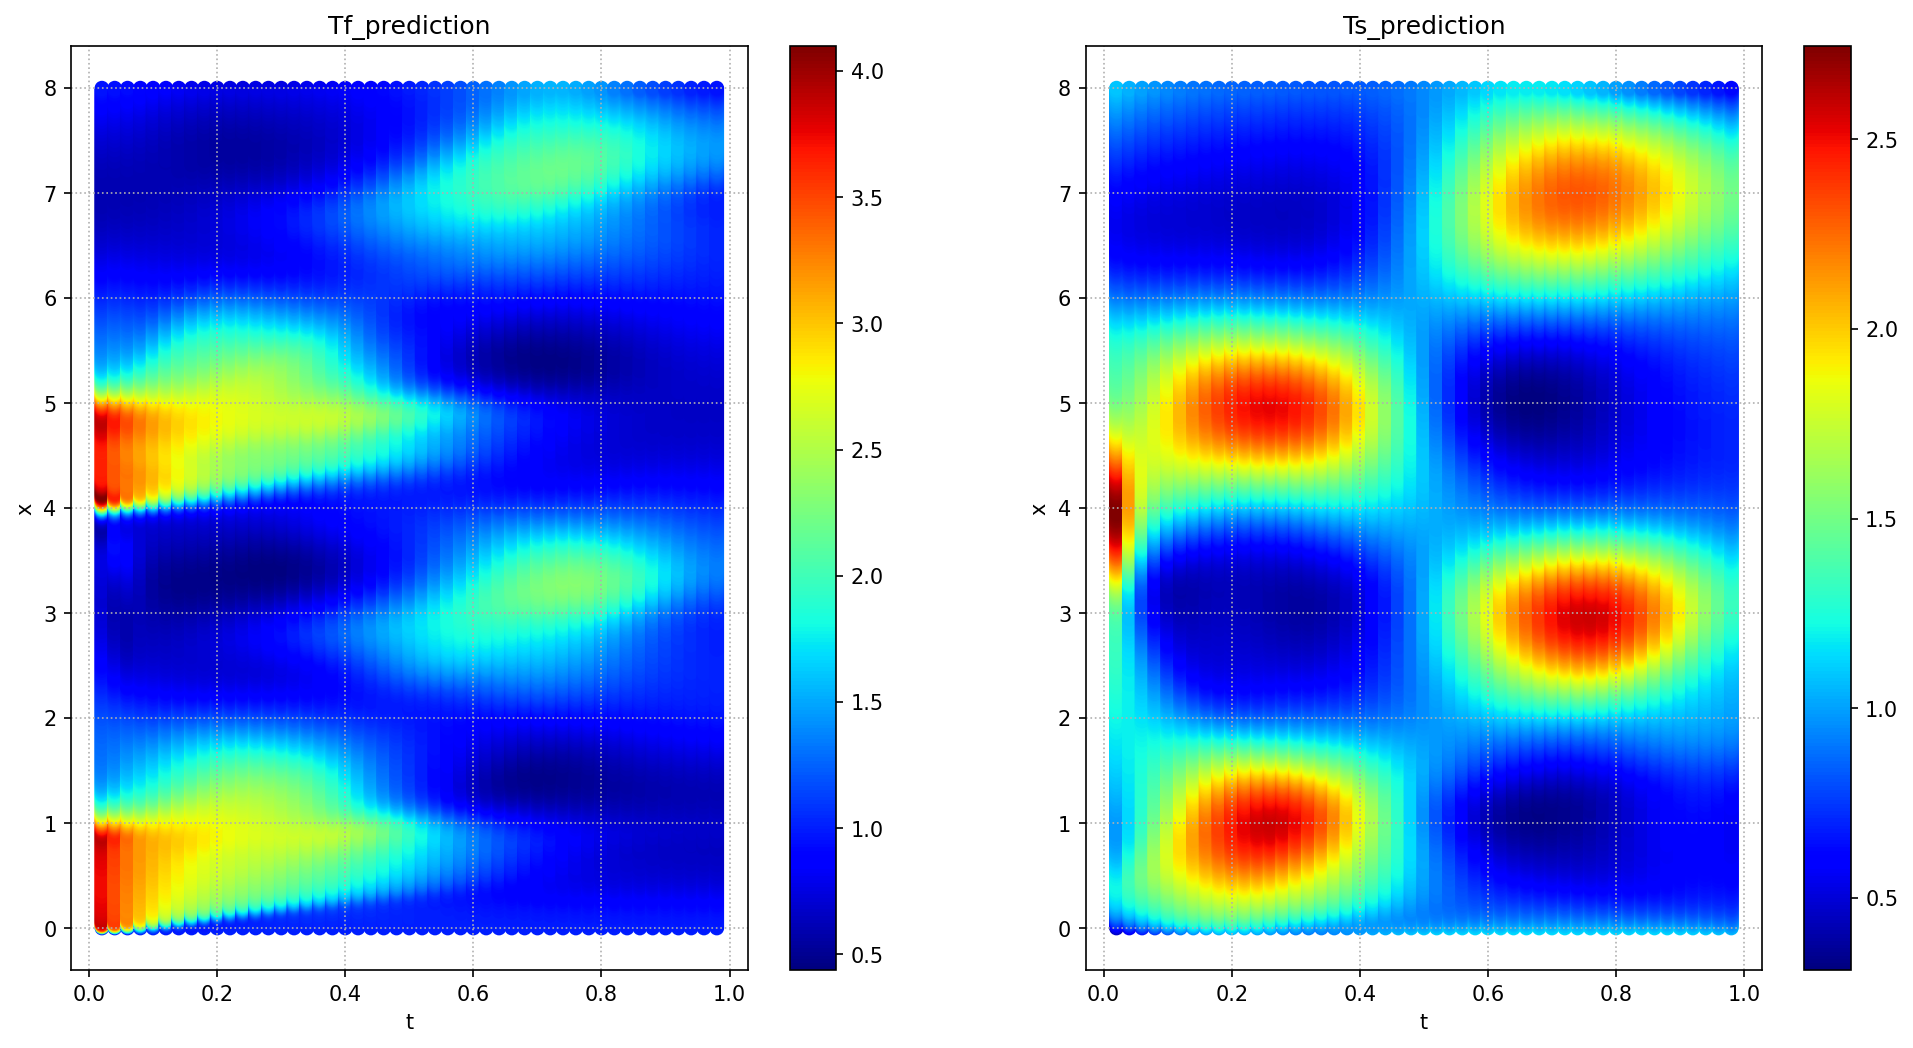

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8), dpi=150)
im1 = axs[0].scatter(input_meas_[:, 1].detach(), input_meas_[:, 0].detach(), c=output.detach(), cmap="jet")
axs[0].set_xlabel("t")
axs[0].set_ylabel("x")
plt.colorbar(im1, ax=axs[0])
axs[0].grid(True, which="both", ls=":")
im2 = axs[1].scatter(input_meas_[:, 1].detach(), input_meas_[:, 0].detach(), c=approximate_conductivity.detach(),
                             cmap="jet")
axs[1].set_xlabel("t")
axs[1].set_ylabel("x")
plt.colorbar(im2, ax=axs[1])
axs[1].grid(True, which="both", ls=":")
axs[0].set_title("Tf_prediction")
axs[1].set_title("Ts_prediction")
plt.show()

In [11]:
Result = torch.zeros(len(input_meas_[:, 0].detach()),3)
Result[:,0] = input_meas_[:, 0].detach()
Result[:,1] = input_meas_[:, 1].detach()
Result[:,2] = approximate_conductivity.detach()
np.savetxt('result_PINNinv.txt',Result, delimiter=',',header='t,x,ts')